# Langgraph 1

In [2]:
%run utilities.ipynb

Dieser Code erstellt einen einfachen Zustandsgraphen mit einem einzigen Knoten und speichert den Verlauf:

1. **Zustandsklasse (AKtenkoffer,um Inforamtionen abzulegen und rauszuholen)**: Die Klasse `State` enthält die Eingabe (`input`) und eine Liste von Nachrichten (`messages`).

2. **Knoten (Agent, der Information erhält, verarbeitet und weitergibt)**: `node1` setzt die Nachricht auf `"node1"` und gibt diese aus.

3. **Graphenerstellung**:
   - Ein `StateGraph`-Builder fügt `node1` als Start- und Endpunkt hinzu.

4. **Speicher**: Ein `MemorySaver` speichert den Ablauf des Zustands.

5. **Visualisierung**: Der Graph wird als Mermaiddiagramm dargestellt.

Ergebnis: Ein einfacher Graph mit einem Start- und Endpunkt im selben Knoten (`node1`), der den Zustand speichert.

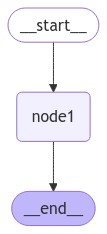

In [12]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
# Set up memory
memory = MemorySaver()

def node1(state:State):
    print("in node 1")
    state["messages"]=state["input"]
    return state 

builder = StateGraph(State)
builder.add_node("node1", node1)
builder.set_entry_point("node1") 
builder.set_finish_point("node1") 

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Um den Graphen auszuführen, kann man entweder graph.invoke oder graph.stream verwenden

 Erklärung zu den Unterschieden zwischen `graph.stream` und `graph.invoke`:

---

Der Unterschied zwischen `graph.stream` und `graph.invoke` liegt oft in der Art und Weise, wie jede Methode die Verarbeitung innerhalb des Graphen handhabt. Hier ist eine allgemeine Erklärung der beiden Methoden basierend auf üblichen Anwendungsfällen:

### 1. **`graph.invoke`**

- **Zweck**: `invoke` ist typischerweise eine einfache Methode, um den gesamten Graphen in einem einzigen Aufruf zu verarbeiten. Sie beginnt am Einstiegspunkt und folgt den definierten Kanten, wobei jeder Knoten der Reihe nach ausgeführt wird, bis entweder ein Endpunkt erreicht wird oder eine Unterbrechung auftritt.
- **Blockierender Aufruf**: Normalerweise wird `invoke` in einer blockierenden Weise ausgeführt, d. h., die Funktion wartet, bis die gesamte Graphenverarbeitung abgeschlossen ist, bevor sie ein Ergebnis zurückgibt.
- **Verwendung**: Ideal für Szenarien, in denen eine Folge von Knoten ohne Unterbrechungen verarbeitet werden soll und das Endergebnis in einem Schritt benötigt wird.

Beispiel:
```python
state = State(input="ein Eingabewert", messages=[])
final_state = graph.invoke(state)
print(final_state["messages"])  # Gibt das Ergebnis nach der vollständigen Verarbeitung des Graphen aus.
```

### 2. **`graph.stream`**

- **Zweck**: Im Gegensatz dazu ist `stream` für die **schrittweise oder Echtzeit-Verarbeitung** ausgelegt. Es ermöglicht, jeden Knoten einzeln zu verarbeiten und nach jedem Knoten die Kontrolle an den Aufrufer zurückzugeben. Dies ist nützlich, wenn die Knoten schrittweise verarbeitet, Zwischenzustände überwacht oder asynchrone Verarbeitungen durchgeführt werden sollen.
- **Nicht-Blockierend / Generator**: `stream` agiert oft wie ein Generator, der jeden Schritt der Graphenverarbeitung nacheinander liefert. So kann bei jedem Schritt der Zustand überprüft oder verändert und optional entschieden werden, ob zum nächsten Knoten fortgefahren werden soll.
- **Verwendung**: Am besten geeignet, wenn man Kontrolle über jeden Schritt im Graphen haben möchte, Zwischenzustände benötigt oder an jedem Knoten eigene Logik hinzufügen will.

Beispiel:
```python
state = State(input="ein Eingabewert", messages=[])
for partial_state in graph.stream(state):
    print(partial_state["messages"])  # Zeigt Nachrichten nach jedem Knoten, Schritt für Schritt.
```

### Zusammenfassungstabelle

| Methode         | Beschreibung                                      | Verarbeitungstyp           | Anwendungsfall |
|-----------------|---------------------------------------------------|-----------------------------|----------------|
| `graph.invoke`  | Führt den gesamten Graphen in einem Rutsch aus    | Blockierend                 | Ideal für einfache Fälle, in denen das Endergebnis nach vollständiger Verarbeitung benötigt wird. |
| `graph.stream`  | Verarbeitet Knoten schrittweise und liefert jeden Zustand einzeln | Nicht-Blockierend / Generator | Geeignet für Echtzeitverarbeitung, Überwachung von Zwischenzuständen oder Anpassung der Logik an jedem Knoten. |

Zusammengefasst:
- Verwende `**invoke**`, wenn der gesamte Graph in einem Schritt verarbeitet werden soll und nur das Endergebnis benötigt wird.
- Verwende `**stream**`, wenn feinere Kontrolle über jeden Schritt erforderlich ist, Zwischenzustände eingesehen oder jeder Knoten einzeln verarbeitet werden soll.

### Invoke

Initialize the state and start the graph

In [4]:
state1=State()
thread = {"configurable": {"thread_id": "1"}}
state1["input"]="hello world"
state1=graph.invoke(state1,thread)

in node 1


In [5]:
print(state1["input"])
print(state1["messages"])


hello world
[HumanMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='7edc1c30-6017-44dc-80d4-3e7df80cf9b3')]


### Stream

Initialize the state and start the graph.

Um den state neu zu initialisieren, nochmal den Graphen compilen

In [6]:
# Input
initial_input = {"input": "hello Dude"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello Dude', 'messages': [HumanMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='7edc1c30-6017-44dc-80d4-3e7df80cf9b3')]}
in node 1
{'input': 'hello Dude', 'messages': [HumanMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='7edc1c30-6017-44dc-80d4-3e7df80cf9b3'), HumanMessage(content='hello Dude', additional_kwargs={}, response_metadata={}, id='2eec0d8f-c767-4624-a9cd-c2a76cac0d3a')]}


# Exercise 1:

Erzeugen Sie eine Panelapp zur Ein und Ausgabe. 
Die Eingabe (question) soll an den Aktenkoffer (=State) eingegeben werden über state["input"]
Die Ausgabe soll in den messages Teil des Aktenkoffers rein.
Die Panelapp soll nur den Inhalt der letzten Message anzeigen.
Unten ist eine Vorlage aus dem panel Notebook.

In [7]:
state=graph.invoke(state,thread)

def input_function(question:str):
    global state
    thread = {"configurable": {"thread_id": "1"}}  
## ÜBERGABE VON QUESTION TO STATE["INPUT"]

    state=graph.invoke()

## GRAPH AUSFÜHREN UND ÜBERGABE VON ANSWER TO STATE
    
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")

## Funktion, welche bei button_click der input_function die Frage, welche in das Widget eingegebn wurde übergibt. 
## Das Resultat von input_function wird an den output übetragen, weler in der App angezeigt wird 
def button_click(event):
    if answer_button.clicks > 0:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in start_button_click: {e}"

answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
answer_button.on_click(button_click)

Tab = pn.Column(
            pn.Row(question),
            pn.panel(answer_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(output, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )


layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

NameError: name 'state' is not defined

# Agentenaustausch (Agenten miteinander verbinden)

In [25]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
# Set up memory
memory = MemorySaver()

def node1(state:State):
    print("start node 1",state["input"])
    state["messages"]=state["input"]
    return state 
def node2(state:State):
    print("start node 2")
    state["messages"]="start node 2"
    return state   
    
def node3(state:State):
    print("start node 3")
    state["messages"]= "start node 3"
    return state

builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_edge("node1", "node2","node3")
builder.set_entry_point("node1") 
builder.set_finish_point("node3") 

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

TypeError: StateGraph.add_edge() takes 3 positional arguments but 4 were given

In [20]:
state=State()
state["input"]="HEllo"
thread = {"configurable": {"thread_id": "1"}} 
state=graph.invoke(state,thread)

start node 1 HEllo
start node 2


## Mit Panel App

In [13]:
state =State()
def input_function(question:str):
    global state
    thread = {"configurable": {"thread_id": "1"}}  
    state["input"]=question
    state=graph.invoke(state,thread)
    answer=state["messages"][-1].content
    print("input_function",answer)
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")

## Funktion, welche bei button_click der input_function die Frage, welche in das Widget eingegebn wurde übergibt. 
## Das Resultat von input_function wird an den output übetragen, weler in der App angezeigt wird 
def button_click(event):
    if answer_button.clicks > 0:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in start_button_click: {e}"

answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
answer_button.on_click(button_click)

Tab = pn.Column(
            pn.Row(question),
            pn.panel(answer_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(output, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )


layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:60810


start node 1 hi
start node 2
input_function start node 2
start node 1 
start node 2
input_function start node 2


# Exercise 2: Fügen Sie einen dritten Agenten (node) ein